# dHybridR M06_th45_ppc10000 Analysis
#### Here we analyze a specific simulation, assuming that FPC data has already been generated

Note: we generate most plots twice, once to make appear in notebook, once to save as png. TODO: streamline this

In [1]:
#Need this to add libraries in parent folder
import sys
sys.path.append('..')
sys.path.append('.')
sys.path.append('../lib')

In [2]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

## Load data

In [3]:
# load analysis file
analysisflnm = '../analysisinputshighparticlecount/m06_th45_ppc10000_input.txt'
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input(flnm = analysisflnm)
path_particles = path+'Output/Raw/Sp01/raw_sp01_{:08d}.h5'

In [4]:
#make results directory
resultstag = 'M06_th45_ppc10000'
resultsdir = resultstag+'results/'
os.system('mkdir ' + resultsdir)

256

In [5]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)


In [6]:
#check that xlim ylim and zlim are not none
#if so, use boundaries of box
cellsizexx = dfields['ex_xx'][1]-dfields['ex_xx'][0]
cellsizeyy = dfields['ex_yy'][1]-dfields['ex_yy'][0]
cellsizezz = dfields['ex_zz'][1]-dfields['ex_zz'][0]

if(xlim is None):
    xlim = [dfields['ex_xx'][0]-cellsizexx/2.,dfields['ex_xx'][-1]+cellsizexx/2.]
if(ylim is None):
    ylim = [dfields['ex_yy'][0]-cellsizeyy/2.,dfields['ex_yy'][-1]+cellsizeyy/2.]
if(zlim is None):
    zlim = [dfields['ex_zz'][0]-cellsizeyy/2.,dfields['ex_zz'][-1]+cellsizeyy/2.]

In [7]:
# load particle data
dparticles = dh5.read_box_of_particles(path_particles, numframe, xlim[0], xlim[1], ylim[0], ylim[1], zlim[0], zlim[1])

In [8]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)

### Lorentz transform fields and shift frame of flow

In [9]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


In [10]:
## (Optional) Check if shock was tracked well. We use the back half in time to fit to a line
#plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [11]:
#loretnz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

#tranform flow
dflow = ft.transform_flow(dflow,vshock)

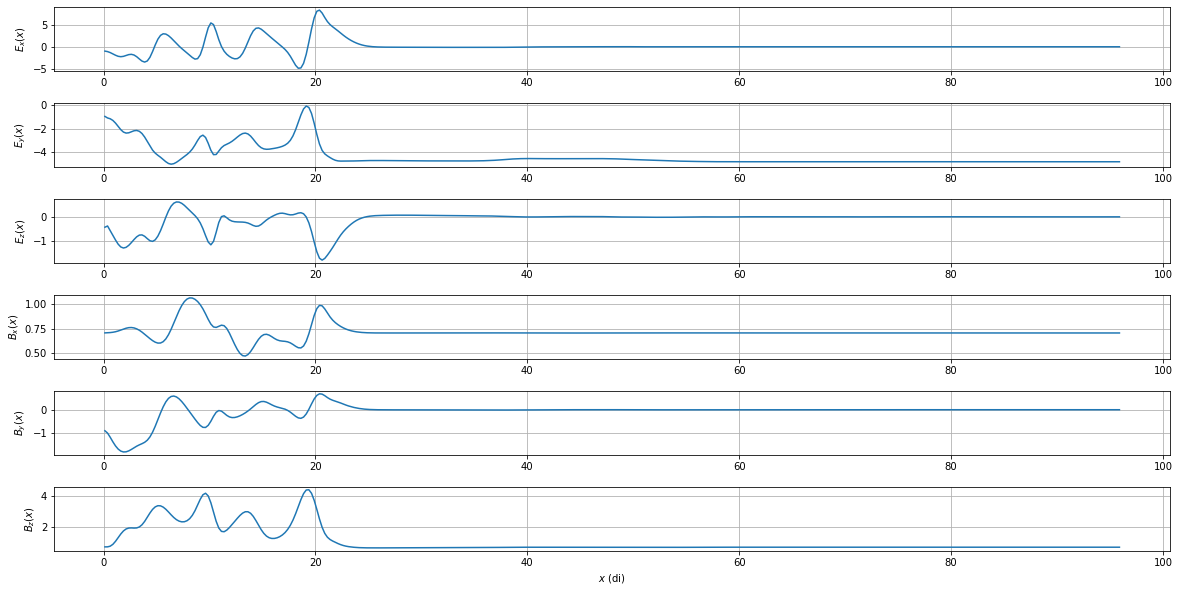

In [12]:
# (Optional) plot all the lorentz transformed fields
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, flnm=resultsdir+resultstag+'fields.png')
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

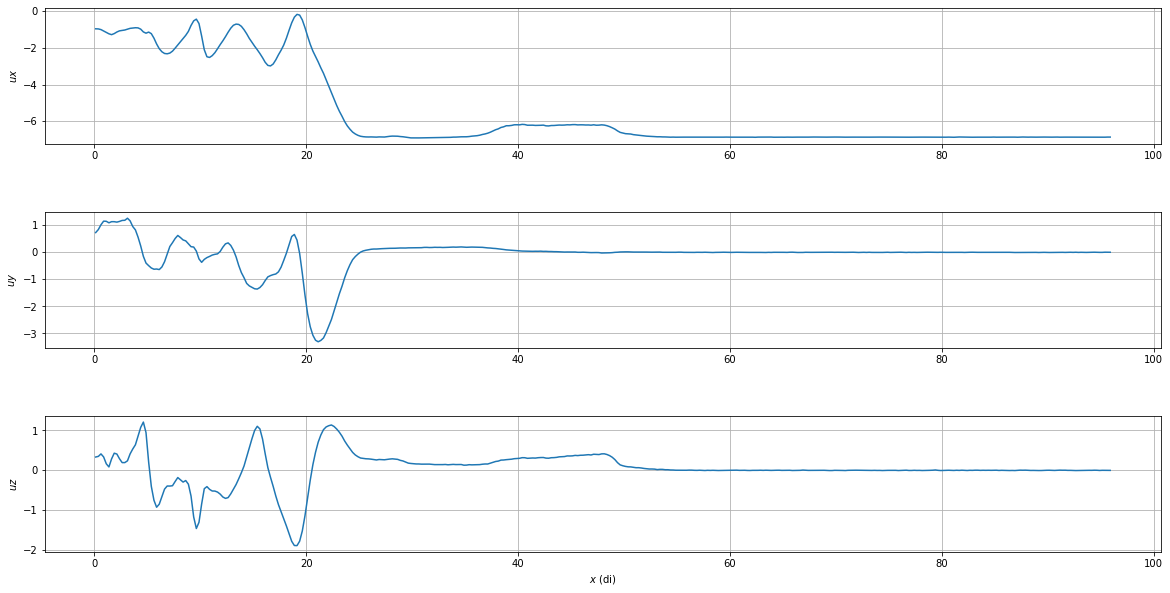

In [13]:
# (Optional) plot flow in the etimated frame of the shock
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, flnm=resultsdir+resultstag+'flow.png')
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Load FPC data

In [14]:
ncflnm = '../M06_th45_ppc10000results/m06_th45_ppc10000.nc'
Hist, CEx, CEy, CEz, vx, vy, vz, x, enerCEx, enerCEy, enerCEz, Vframe_relative_to_sim, metadata_in, params_in = dnc.load3Vnetcdf4(ncflnm)

### Look for signature bounds

In [15]:
startval = 19.0#lower bound for sda metadata = 1 (di)
endval = 25.5#upper bound for sda metadata = 1 (di)

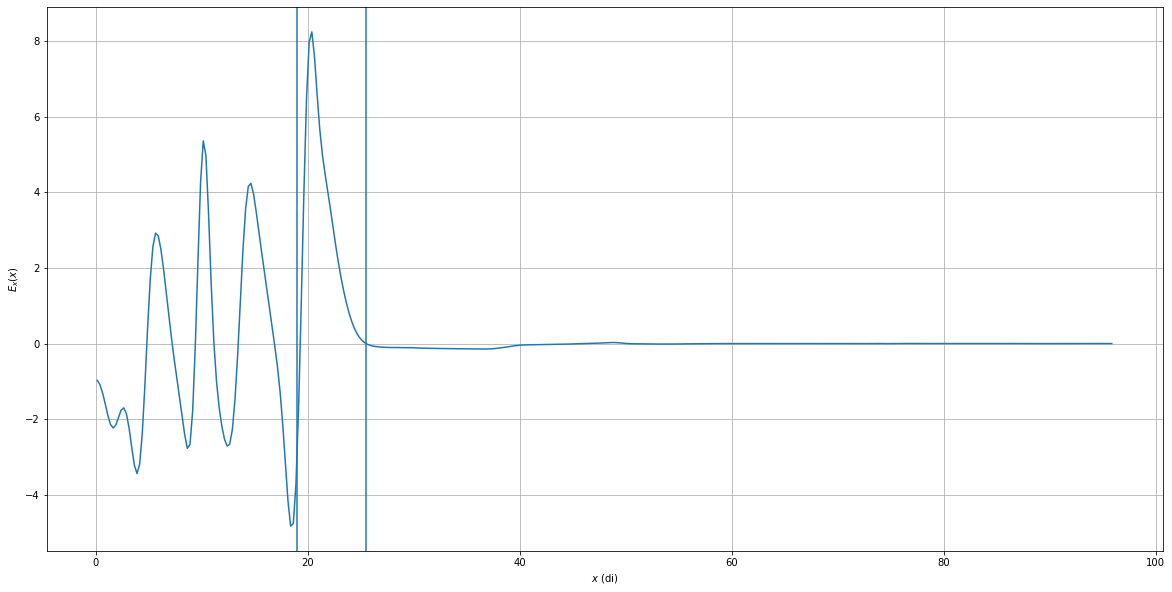

In [16]:
#option one, use Ex(x,y=0,z=0) to find SDA bounds. Should range from the start of the ramp to the first zero crossing
yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval,flnm=resultsdir+resultstag+'shockbounds.png')
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

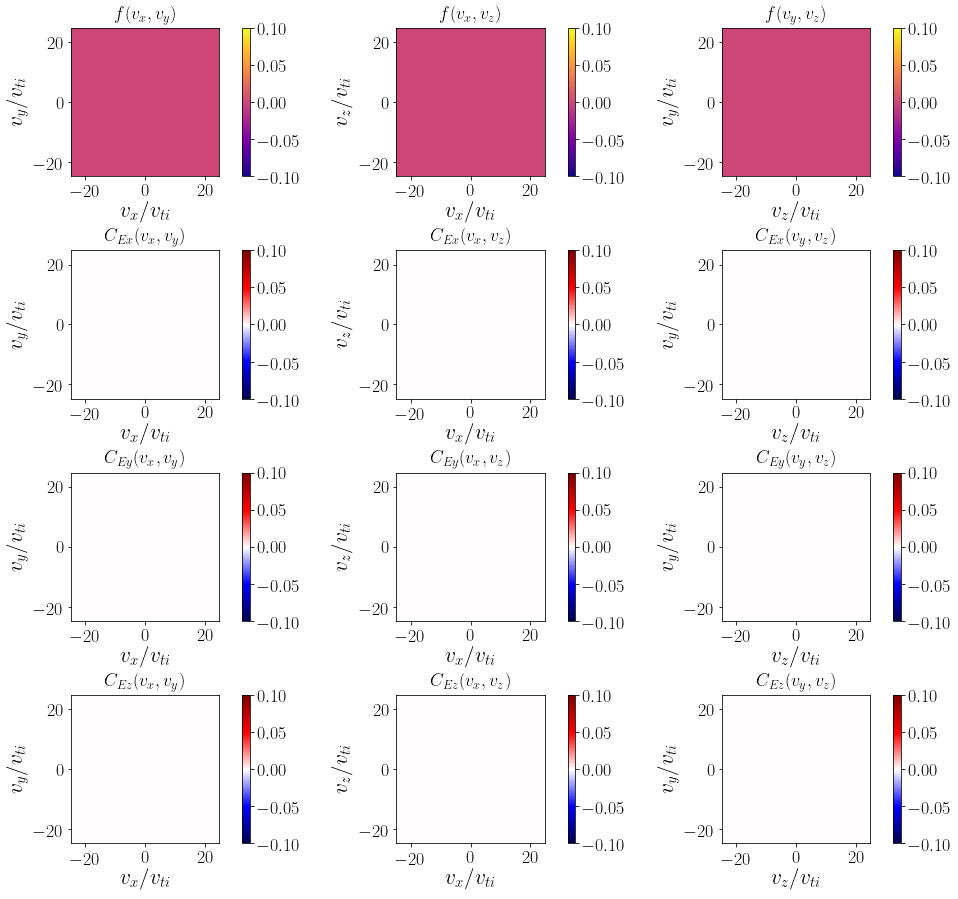

In [17]:
#option two (better but harder), look at the FPC signatures and see when the shock starts and stops

#Plot FPCs and dist funcs at start val-------------------------------------------------------------
#grab index of starval
i = ao.find_nearest(x, startval)

#Project onto 2d axis
H_xy = ao.array_3d_to_2d(Hist[i],'xy')
H_xz = ao.array_3d_to_2d(Hist[i],'xz')
H_yz = ao.array_3d_to_2d(Hist[i],'yz')
CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
CEx_xz = ao.array_3d_to_2d(CEx[i],'xz')
CEx_yz = ao.array_3d_to_2d(CEx[i],'yz')
CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
CEy_xz = ao.array_3d_to_2d(CEy[i],'xz')
CEy_yz = ao.array_3d_to_2d(CEy[i],'yz')
CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
CEz_xz = ao.array_3d_to_2d(CEz[i],'xz')
CEz_yz = ao.array_3d_to_2d(CEz[i],'yz')

#plot
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz,flnm=resultsdir+resultstag+'superplotstartval.png')
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

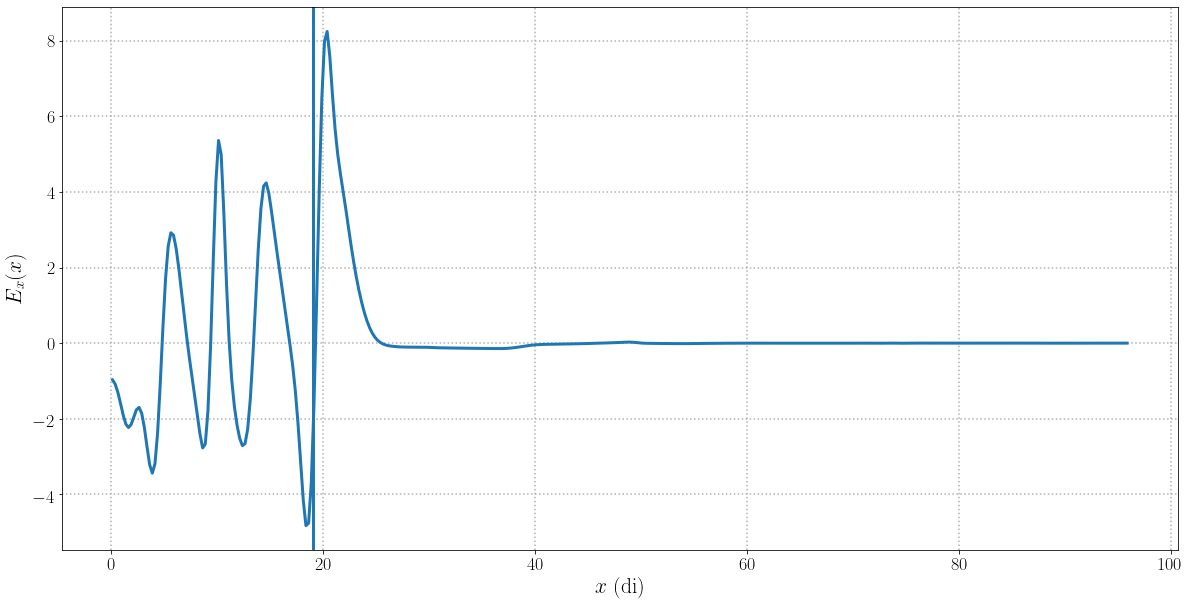

In [18]:
#plot where above signature is
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval,flnm=resultsdir+resultstag+'startvalpos.png')
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval)

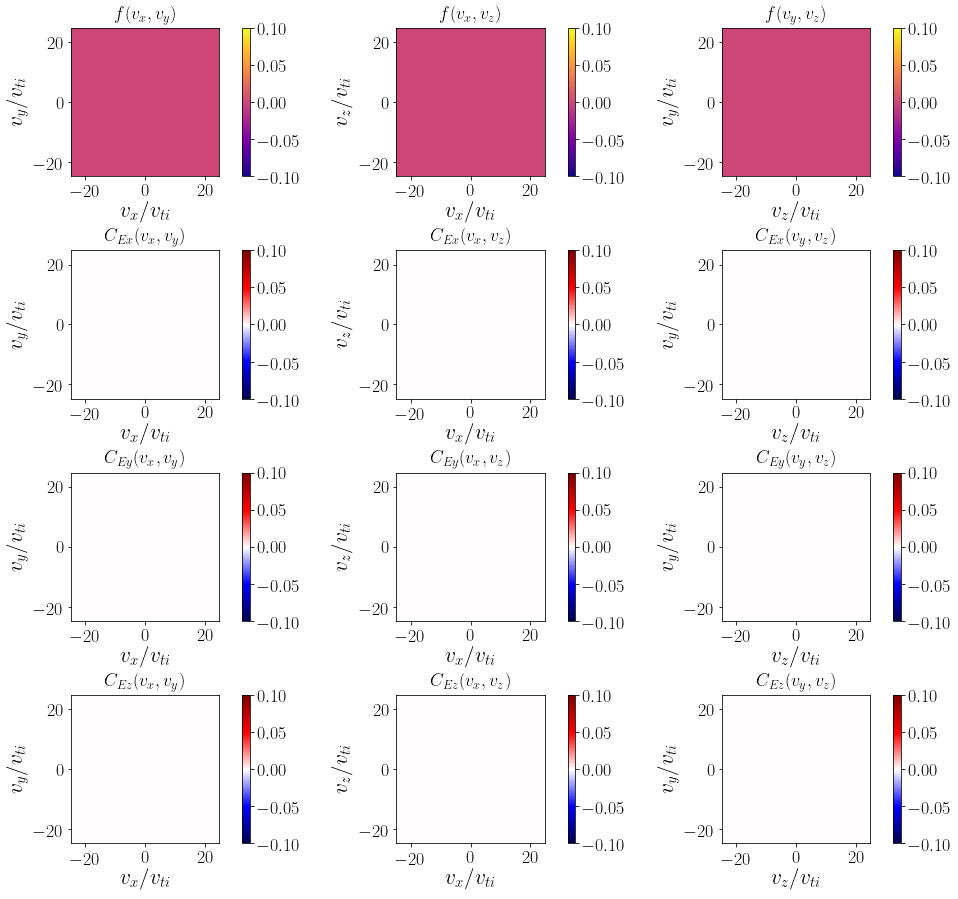

In [19]:
#Plot FPCs and dist funcs at end val--------------------------------------------------------------
#grab index of starval
i = ao.find_nearest(x, endval)

#Project onto 2d axis
H_xy = ao.array_3d_to_2d(Hist[i],'xy')
H_xz = ao.array_3d_to_2d(Hist[i],'xz')
H_yz = ao.array_3d_to_2d(Hist[i],'yz')
CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
CEx_xz = ao.array_3d_to_2d(CEx[i],'xz')
CEx_yz = ao.array_3d_to_2d(CEx[i],'yz')
CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
CEy_xz = ao.array_3d_to_2d(CEy[i],'xz')
CEy_yz = ao.array_3d_to_2d(CEy[i],'yz')
CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
CEz_xz = ao.array_3d_to_2d(CEz[i],'xz')
CEz_yz = ao.array_3d_to_2d(CEz[i],'yz')

#plot
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz,flnm=resultsdir+resultstag+'superplotendval.png')
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

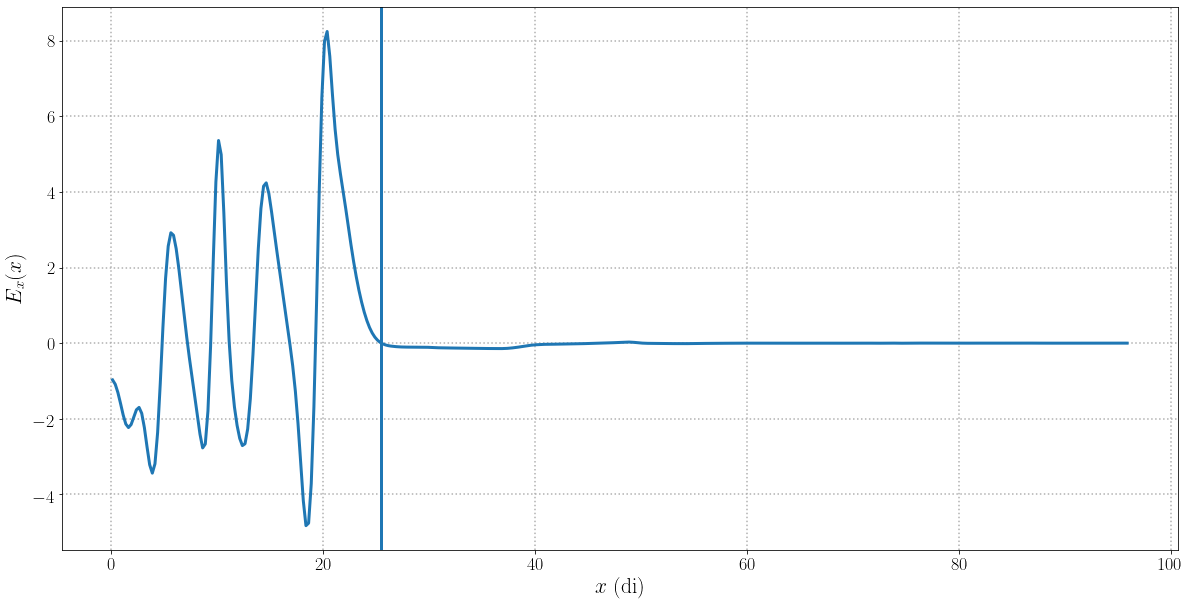

In [20]:
#plot where above signature is
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = endval,flnm=resultsdir+resultstag+'endvalpos.png')
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = endval)

In [21]:
#set metadata using add Metadata script
cmd = 'python3 ../scripts/addMetadata.py ' + analysisflnm + ' ' + ncflnm + ' ' + str(startval) + ' ' + str(endval)
os.system(cmd)

0

### Look for shock rippling

#### Make pmesh of fields

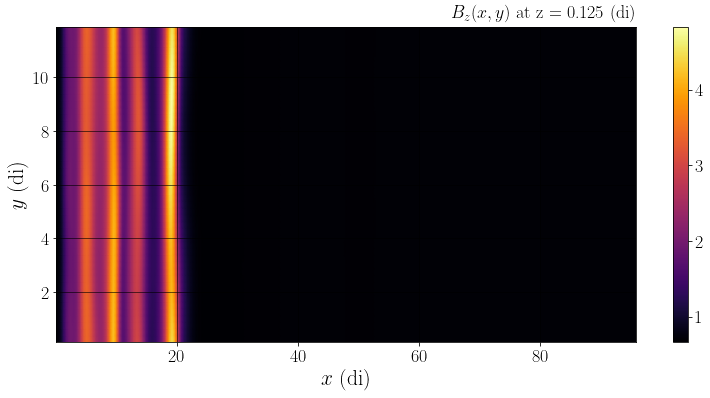

In [22]:
#plot xy plane at z=0 
plt2d.make_field_pmesh(dfields,'bz','xy',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=None,xlimmax=None,flnm=resultsdir+resultstag+'Bzpmesh.png')
plt2d.make_field_pmesh(dfields,'bz','xy',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=None,xlimmax=None)

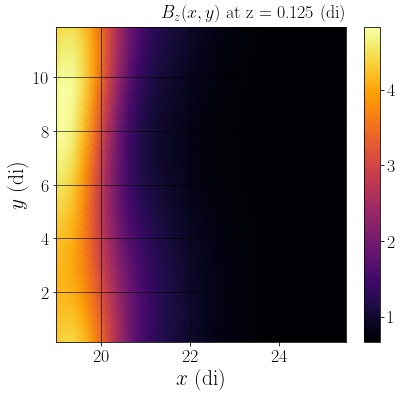

In [23]:
#zoom in on potential ripple xy plane at z=0
plt2d.make_field_pmesh(dfields,'bz','xy',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=startval,xlimmax=endval,flnm=resultsdir+resultstag+'Bzpeshzoomed.png')
plt2d.make_field_pmesh(dfields,'bz','xy',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=startval,xlimmax=endval)

#### Make stacked line plot

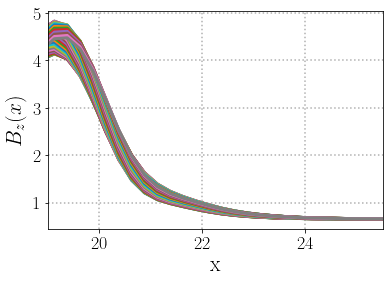

In [24]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=startval,xhigh=endval,flnm=resultsdir+resultstag+'stackedripple.png')
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=startval,xhigh=endval)

### Diagnose corrugation instability
#### look at number of significant wave modes in fourier space
#### still WIP

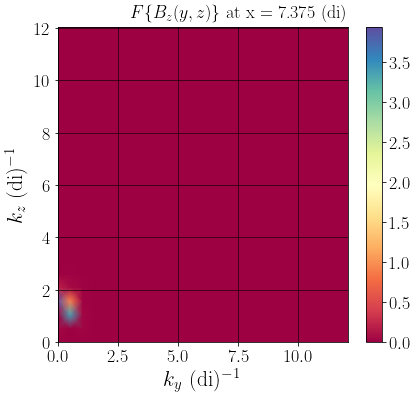

In [25]:
shockval = 15.0 #di, some slice in the ramp of the shock
i = ao.find_nearest(x, shockval)
pltfr.plot_fft_norm(dfields,'bz','yz',takeaxisaverage=False, xxindex=i, yyindex=float('nan'), zzindex=float('nan'), plotlog = False, xaxislim=None, yaxislim=None,flnm=resultsdir+resultstag+'2dfftinramp.png')
pltfr.plot_fft_norm(dfields,'bz','yz',flnm = '',takeaxisaverage=False, xxindex=i, yyindex=float('nan'), zzindex=float('nan'), plotlog = False, xaxislim=None, yaxislim=None)

### Generate sweep gifs

#### Generate sweeps of superplot

In [26]:
pltvv.make_superplot_gif(vx,vy,vz,vmax,Hist,CEx,CEy,CEz,x,resultsdir+'superplotscanfiles',resultsdir+resultstag+'superplot.gif')

Making plot 0 of 191
Making plot 1 of 191
Making plot 2 of 191
Making plot 3 of 191
Making plot 4 of 191
Making plot 5 of 191
Making plot 6 of 191
Making plot 7 of 191
Making plot 8 of 191
Making plot 9 of 191
Making plot 10 of 191
Making plot 11 of 191
Making plot 12 of 191
Making plot 13 of 191
Making plot 14 of 191
Making plot 15 of 191
Making plot 16 of 191
Making plot 17 of 191
Making plot 18 of 191
Making plot 19 of 191
Making plot 20 of 191
Making plot 21 of 191
Making plot 22 of 191
Making plot 23 of 191
Making plot 24 of 191
Making plot 25 of 191
Making plot 26 of 191
Making plot 27 of 191
Making plot 28 of 191
Making plot 29 of 191
Making plot 30 of 191
Making plot 31 of 191
Making plot 32 of 191
Making plot 33 of 191
Making plot 34 of 191
Making plot 35 of 191
Making plot 36 of 191
Making plot 37 of 191
Making plot 38 of 191
Making plot 39 of 191
Making plot 40 of 191
Making plot 41 of 191
Making plot 42 of 191
Making plot 43 of 191
Making plot 44 of 191
Making plot 45 of 19

In [27]:
rsltmng.make_gif_from_folder(resultsdir+'superplotscanfiles',resultsdir+resultstag+'superplot.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png', '000020.png', '000021.png', '000022.png', '000023.png', '000024.png', '000025.png', '000026.png', '000027.png', '000028.png', '000029.png', '000030.png', '000031.png', '000032.png', '000033.png', '000034.png', '000035.png', '000036.png', '000037.png', '000038.png', '000039.png', '000040.png', '000041.png', '000042.png', '000043.png', '000044.png', '000045.png', '000046.png', '000047.png', '000048.png', '000049.png', '000050.png', '000051.png', '000052.png', '000053.png', '000054.png', '000055.png', '000056.png', '000057.png', '000058.png', '000059.png', '000060.png', '000061.png', '000062.png', '000063.png', '000064.png', '000065.png', '000066.png', '000067.png', '000068.png', '000069.png', '000070.png', '0000

In [28]:
plt1d.make_field_scan_gif(dfields,'ex',resultsdir+'fieldscanfiles',resultsdir+resultstag+'scan.gif')

Making plot 0 of 384
Making plot 1 of 384
Making plot 2 of 384
Making plot 3 of 384
Making plot 4 of 384
Making plot 5 of 384
Making plot 6 of 384
Making plot 7 of 384
Making plot 8 of 384
Making plot 9 of 384
Making plot 10 of 384
Making plot 11 of 384
Making plot 12 of 384
Making plot 13 of 384
Making plot 14 of 384
Making plot 15 of 384
Making plot 16 of 384
Making plot 17 of 384
Making plot 18 of 384
Making plot 19 of 384
Making plot 20 of 384
Making plot 21 of 384
Making plot 22 of 384
Making plot 23 of 384
Making plot 24 of 384
Making plot 25 of 384
Making plot 26 of 384
Making plot 27 of 384
Making plot 28 of 384
Making plot 29 of 384
Making plot 30 of 384
Making plot 31 of 384
Making plot 32 of 384
Making plot 33 of 384
Making plot 34 of 384
Making plot 35 of 384
Making plot 36 of 384
Making plot 37 of 384
Making plot 38 of 384
Making plot 39 of 384
Making plot 40 of 384
Making plot 41 of 384
Making plot 42 of 384
Making plot 43 of 384
Making plot 44 of 384
Making plot 45 of 38

Making plot 362 of 384
Making plot 363 of 384
Making plot 364 of 384
Making plot 365 of 384
Making plot 366 of 384
Making plot 367 of 384
Making plot 368 of 384
Making plot 369 of 384
Making plot 370 of 384
Making plot 371 of 384
Making plot 372 of 384
Making plot 373 of 384
Making plot 374 of 384
Making plot 375 of 384
Making plot 376 of 384
Making plot 377 of 384
Making plot 378 of 384
Making plot 379 of 384
Making plot 380 of 384
Making plot 381 of 384
Making plot 382 of 384
Making plot 383 of 384


In [29]:
rsltmng.make_gif_from_folder(resultsdir+'fieldscanfiles',resultsdir+resultstag+'fieldscan.gif')

['000000', '000001', '000002', '000003', '000004', '000005', '000006', '000007', '000008', '000009', '000010', '000011', '000012', '000013', '000014', '000015', '000016', '000017', '000018', '000019', '000020', '000021', '000022', '000023', '000024', '000025', '000026', '000027', '000028', '000029', '000030', '000031', '000032', '000033', '000034', '000035', '000036', '000037', '000038', '000039', '000040', '000041', '000042', '000043', '000044', '000045', '000046', '000047', '000048', '000049', '000050', '000051', '000052', '000053', '000054', '000055', '000056', '000057', '000058', '000059', '000060', '000061', '000062', '000063', '000064', '000065', '000066', '000067', '000068', '000069', '000070', '000071', '000072', '000073', '000074', '000075', '000076', '000077', '000078', '000079', '000080', '000081', '000082', '000083', '000084', '000085', '000086', '000087', '000088', '000089', '000090', '000091', '000092', '000093', '000094', '000095', '000096', '000097', '000098', '000099',